In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# Here every element in a dataset is a batch of 32 elements.

len(dataset)

68

In [6]:
# dataset.head()

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    
# gives the batch size 

(32, 256, 256, 3)
[0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 2 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0]


2023-06-21 21:49:50.081479: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


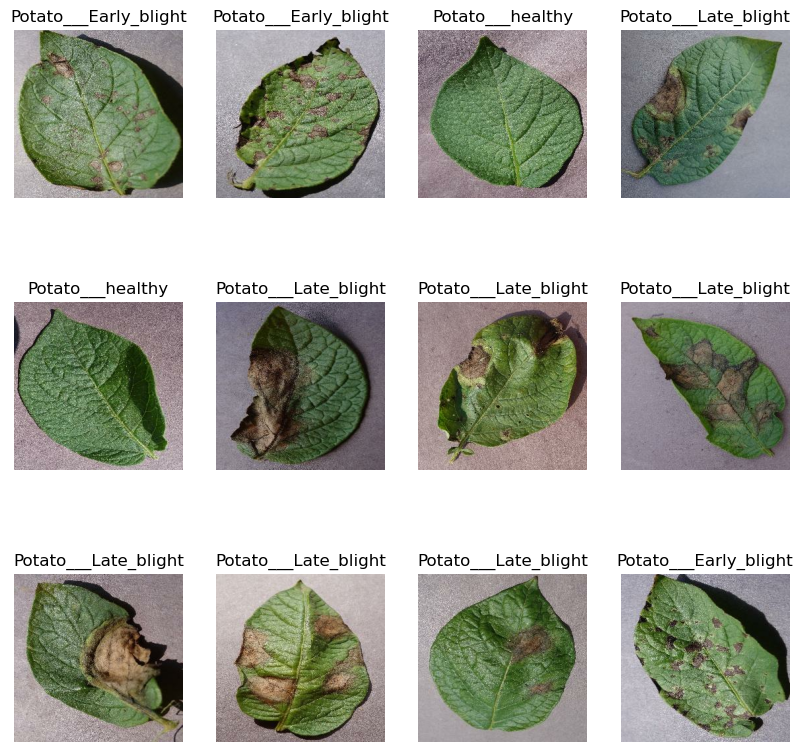

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("int32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% ==> Training
# 20% ==> 10% => Validation, 10%=>Test

In [10]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(dataset, test_size=0.2, random_state = 42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [11]:
test_size = 0.8
len(dataset)*test_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_val_ds = dataset.skip(54)
len(test_val_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_val_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_val_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(test_ds)

8

In [20]:
# cache()
# Will read the image from disk and for next iteration if we need same image, it will keep that image in memory.
# This will improve the performance of the pipeline.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),    # RESIZING
    layers.experimental.preprocessing.Rescaling(1.0/255)    # NORMALIZATION
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
# Build CNN model 

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer="adam",
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 27s 438ms/step - loss: 0.9131 - accuracy: 0.4890 - val_loss: 0.8816 - val_accuracy: 0.4531
Epoch 2/10
54/54 [==============================] - 21s 391ms/step - loss: 0.7114 - accuracy: 0.6516 - val_loss: 0.5592 - val_accuracy: 0.7500
Epoch 3/10
54/54 [==============================] - 19s 355ms/step - loss: 0.4244 - accuracy: 0.8131 - val_loss: 0.3516 - val_accuracy: 0.8646
Epoch 4/10
54/54 [==============================] - 20s 373ms/step - loss: 0.3998 - accuracy: 0.8391 - val_loss: 0.6068 - val_accuracy: 0.7292
Epoch 5/10
54/54 [==============================] - 20s 367ms/step - loss: 0.2630 - accuracy: 0.8924 - val_loss: 0.2451 - val_accuracy: 0.9115
Epoch 6/10
54/54 [==============================] - 19s 344ms/step - loss: 0.2250 - accuracy: 0.9068 - val_loss: 0.4802 - val_accuracy: 0.8229
Epoch 7/10
54/54 [==============================] - 22s 411ms/step - loss: 0.2497 - accuracy: 0.8970 - val_loss: 0.3477 - val_accuracy: 0.8594

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 118ms/step - loss: 0.0942 - accuracy: 0.9688


In [28]:
scores

[0.0942080020904541, 0.96875]

In [29]:
history

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

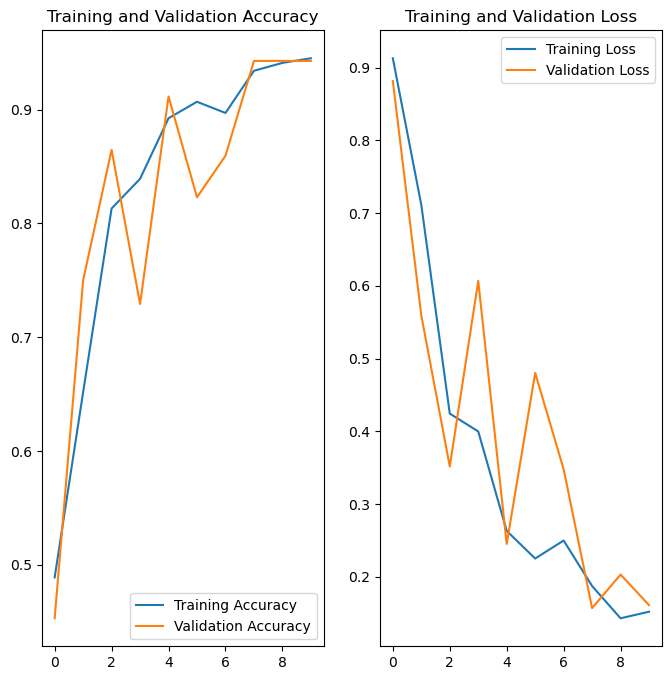

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image actual label: Potato___Early_blight
1/1 [==============================] - 0s 164ms/step
Predicted label: Potato___Early_blight


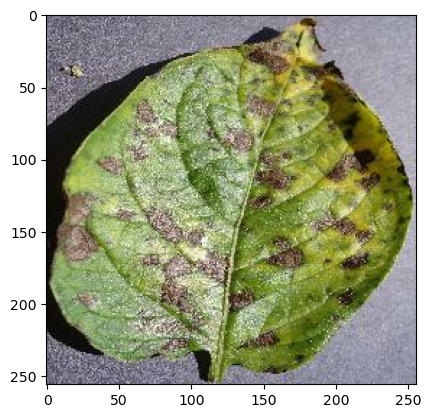

In [33]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('int32')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [34]:
# Function for Prediction

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


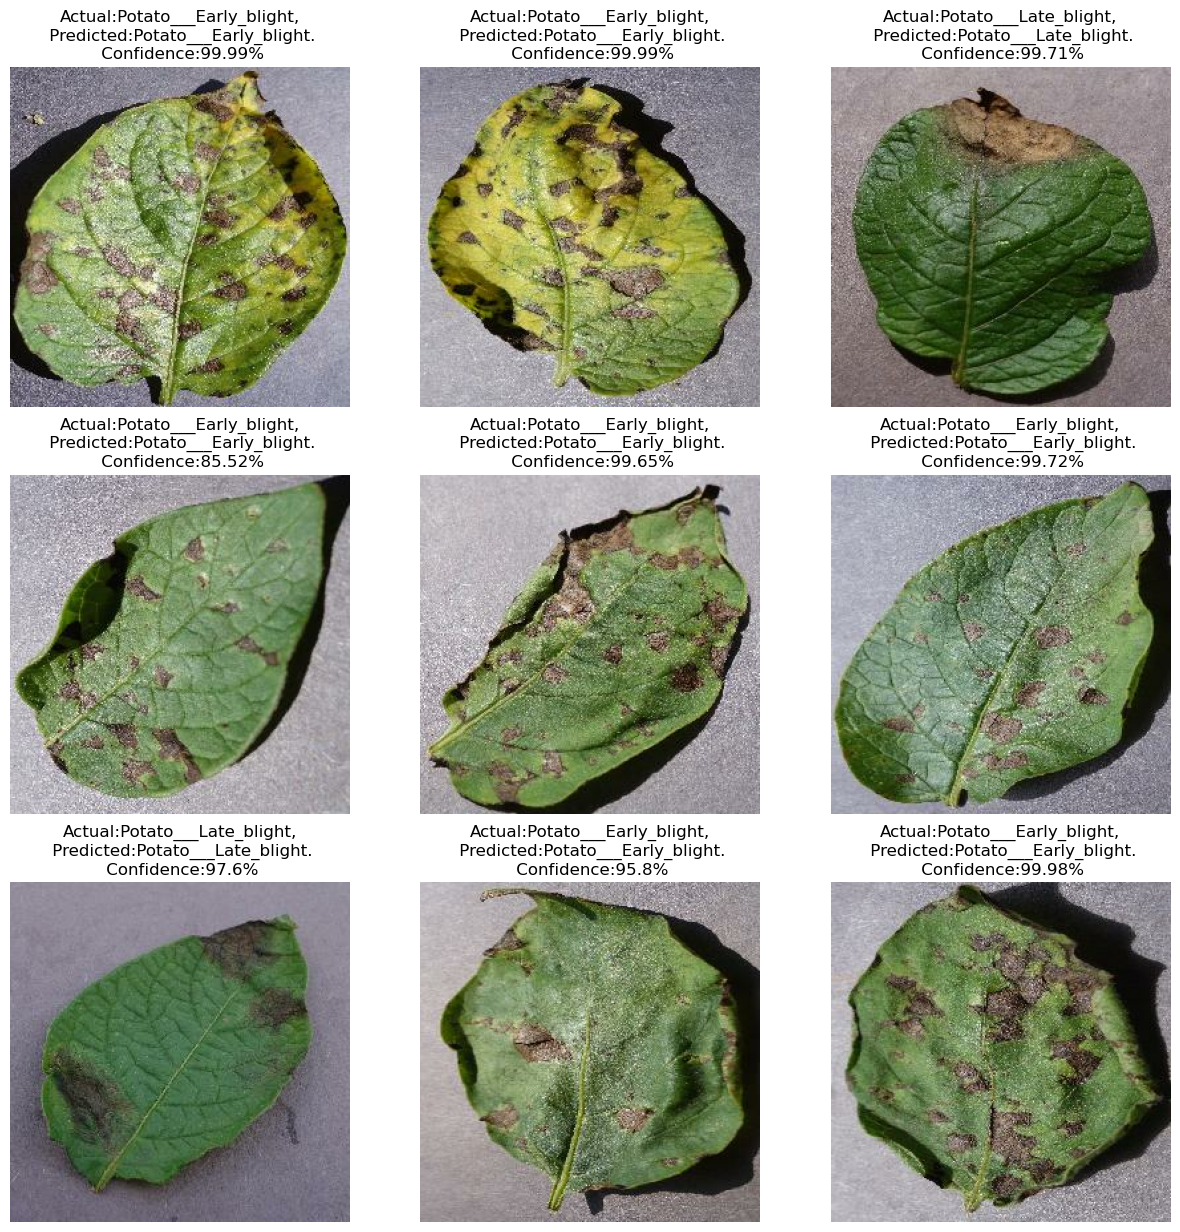

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('int32'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")

In [38]:
import os
model_version = max([int(i) for i in os.listdir("./saved_models") if i != ".DS_Store"])+1
model.save(f"./saved_models/{model_version}")

INFO:tensorflow:Assets written to: ./saved_models/3/assets


INFO:tensorflow:Assets written to: ./saved_models/3/assets


In [ ]:
# model_version = 1
# model.save(f"./saved_models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets
